In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os, sys
sys.path.append('..')
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
tqdm.monitor_interval = 0

In [35]:
history = glob('../data/history/*')
print(len(history))

245


In [36]:
route_integrity = []
for hfile in tqdm(history):
    mat = np.load(hfile)
    total = mat.shape[0] * mat.shape[1]
    nMissing = np.count_nonzero(np.isnan(mat))
    integ = (total - nMissing) / total
    
    route_integrity.append(
        dict(
            name=fileName(hfile), 
            integ=integ,
            seglen=mat.shape[1]))

100%|██████████| 245/245 [00:00<00:00, 673.46it/s]


In [37]:
routes = route_integrity
routes = list(reversed(sorted(routes, key=lambda ent: ent['integ'])))
routes = list(filter(lambda one: one['seglen'] > 10, routes))

In [38]:
print(len(routes))
for route in routes[:50]:
    print(
        route['seglen'], 
        route['name'], 
        '%.1f%%' % (route['integ'] * 100))
print('...')
for route in routes[::-1][:10][::-1]:
    print(
        route['seglen'], 
        route['name'], 
        '%.1f%%' % (route['integ'] * 100))

242
40 Q10_0 89.9%
59 M102_0 87.1%
41 Bx15_0 86.0%
36 Q4_0 85.8%
30 Q44-SBS_0 85.7%
75 B6_0 85.0%
55 B35_0 84.7%
50 Q5_0 84.6%
18 M60-SBS_0 84.6%
53 Q85_0 83.8%
14 M86-SBS_0 83.7%
74 B15_0 83.6%
77 M101_0 83.3%
57 Q58_0 83.2%
53 M103_0 82.9%
74 Q27_0 82.9%
50 Q17_0 82.8%
54 B41_0 82.5%
54 B46_0 82.4%
28 M14D_0 82.2%
37 Bx9_0 82.2%
46 Q3_0 81.9%
50 Bx36_0 81.4%
56 Q46_0 80.8%
62 M7_0 80.7%
48 Q43_0 80.5%
24 Q53_0 79.9%
41 Bx19_0 79.7%
42 Q12_0 79.5%
61 M15_0 79.4%
75 B82_0 79.3%
46 S53_0 78.9%
45 Q83_0 78.9%
13 M79-SBS_0 78.8%
27 Bx35_0 78.2%
35 B52_0 78.1%
33 Q2_0 78.0%
41 Bx7_0 78.0%
49 B38_0 77.9%
27 M14A_0 77.6%
44 Q1_0 77.4%
19 M116_0 77.4%
32 Bx41_0 76.4%
57 Bx28_0 76.3%
45 Bx1_0 76.2%
51 B68_0 76.0%
25 Bx13_0 75.8%
39 Bx10_0 75.8%
48 Bx2_0 75.8%
38 Q28_0 75.7%
...
31 X38_0 27.8%
17 M98_0 27.1%
26 X22A_0 27.1%
45 X15_0 26.2%
41 S55_0 22.2%
15 X21_0 18.0%
14 S89_0 17.8%
32 X63_0 16.0%
25 X68_0 15.2%
26 X64_0 10.2%


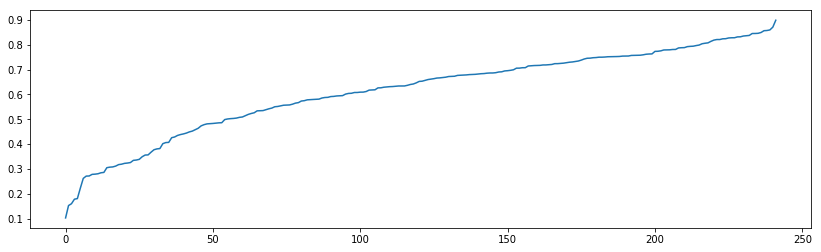

In [39]:
integs = [route['integ'] for route in routes]
plt.figure(figsize=(14, 4))
plt.plot(sorted(integs))
plt.show(); plt.close()

In [113]:
MIN_LAG=6
# MIN_LAG=12
MIN_STOPS=5

def trainable_inds(
        datamat,
        lag=6, # 5 timesteps (50 mins) of data availble
        stops=10, # at least N stops back available
    ):
    # returns usable time-locale sections of the time-locale matrix
    tsize, ssize = datamat.shape
    inds = [] # ((at time, at stop, max poss. stops back))
    ti = lag
    while ti < tsize:
        toff = 1
#     for ti in range(lag, tsize):
        si = stops
        while si < ssize:
            soff = 1
#         for si in range(minStops, ssize):
            series = datamat[ti-lag:ti, si-stops:si]
            if not np.count_nonzero(np.isnan(series)):
                assert not np.count_nonzero(np.isnan(datamat[ti-lag:ti, si-stops:si]))
                inds.append((ti, si))
                toff = lag//4
#                 soff = stops
            si += soff
        ti += toff
                
    return inds

# data = history_byname('Q10_0', root='../data/history')
data = history_byname('M102_0', root='../data/history')
print(data.shape)
segInds = trainable_inds(data, lag=MIN_LAG, stops=MIN_STOPS)
print(len(segInds), '%.3f%%' % (len(segInds) / (data.shape[0] * data.shape[1]) * 100))

SIND = 30
print(len([seg for seg in segInds if seg[1] == SIND]))
print(np.count_nonzero(np.isnan(data[:, SIND])))

(13248, 59)
419294 53.643%
9524
1179


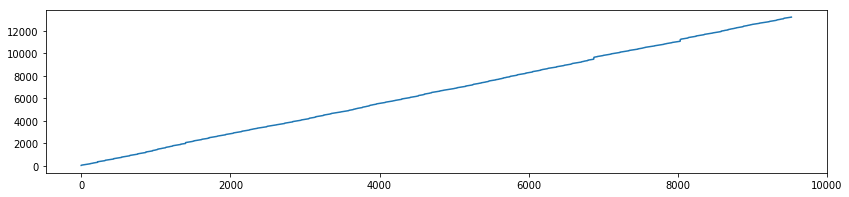

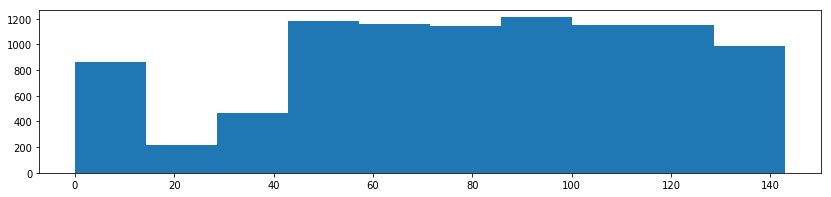

In [114]:
plt.figure(figsize=(14, 3))
plt.plot(sorted([seg[0] for seg in segInds if seg[1] == SIND]))
plt.show(); plt.close()

plt.figure(figsize=(14, 3))
plt.hist(sorted([seg[0] % (6 * 24) for seg in segInds if seg[1] == SIND]))
plt.show(); plt.close()

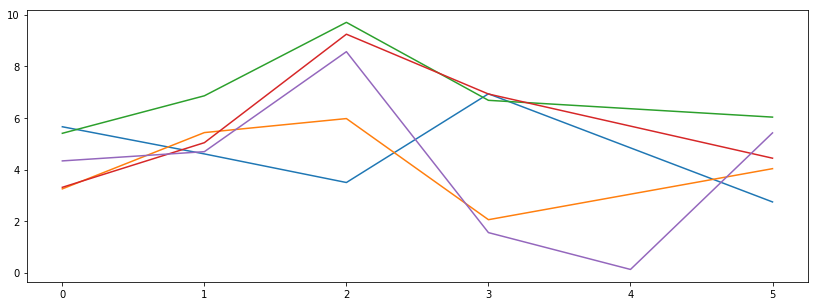

In [115]:
# print(segInds[0])
ti, si = segInds[0]
plt.figure(figsize=(14, 5))
for ii in range(si-5, si):
    plt.plot(data[ti-MIN_LAG:ti, ii])
plt.show(); plt.close()

In [116]:
for route in tqdm(routes):
    data = history_byname(route['name'], root='../data/history')
    inds = trainable_inds(data, lag=MIN_LAG, stops=MIN_STOPS)
    route['trainable'] = inds

100%|██████████| 242/242 [05:13<00:00,  1.30s/it]


In [117]:
h_name = int(MIN_LAG // 6)
print(h_name)

1


In [118]:
import json

for route in tqdm(routes):
    fpath = '../metadata/%dh/%s.json' % (h_name, route['name'])
#     print(fpath)
    with open(fpath, 'w') as fl:
        json.dump(route, fl, indent=4)
#     break

100%|██████████| 242/242 [02:40<00:00,  1.50it/s]
